In [1]:
# #### Notebook to view maps of MSE and related variables from TC output
# 
# Assumes key integrated variables have been processed and written out by PE_write.py to single-level netcdf files.
# 
# James Ruppert  
# jruppert@ou.edu  
# 4/9/23

In [2]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
from matplotlib import colors
import os
import cartopy
import sys
from mask_tc_track import mask_tc_track
import pandas as pd
from precip_class import precip_class

In [3]:
# #### Main settings

# #### Variable selection

storm = 'haiyan'
# storm = 'maria'

# How many members
# nmem = 10 # number of ensemble members
nmem = 1
imemb = 1 # Which member to plot?

# Time step to plot (CTL)
it_plt0=36

ptop = 100 # top for integrals; hPa
prplot = 600 # hPa level for winds

formula='vadv'#'hflux'#'converg'#

In [4]:
# Other settings

# #### Directories

figdir = "/home/jamesrup/figures/tc/ens/mse/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"

def get_tshift(itest):
    if itest == 'ctl':
        tshift=0
    elif itest == 'ncrf36h':
        tshift=36
    elif itest == 'ncrf48h':
        tshift=48
    return tshift

# Tests to read and compare
ntest=2
if storm == 'haiyan':
    tests = ['ctl','ncrf36h']
elif storm == 'maria':
#        tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']

# Ens member strings
imemb-=1 # index of member to read
memb0=1 # Starting member to read
nums=np.arange(memb0,nmem+memb0,1)
nums=nums.astype(str)
nustr = np.char.zfill(nums, 2)
memb_all=np.char.add('memb_',nustr)

In [5]:
# WRFOUT file list
path = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'
dirlist = os.listdir(path)
subs="wrfout_d02"
wrf_files = list(filter(lambda x: subs in x, dirlist))
wrf_files.sort()
wrf_files = [path + s for s in wrf_files]
nwrf=len(wrf_files)

# Get Lat/Lon
varfil_main = Dataset(wrf_files[0])
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
varfil_main.close()
lon1d=lon[0,:]
lat1d=lat[:,0]

datdir = path+'/post/d02/'
fil = Dataset(datdir+'U.nc') # this opens the netcdf file
pres = fil.variables['pres'][:] # hPa
delp=(pres[0]-pres[1])*1e2
fil.close()
nk=np.size(pres)
iktop = np.where(pres == ptop)[0][0]

ikplot = np.where(pres == prplot)[0][0]

In [6]:
# Create arrays

nt = np.zeros(ntest, dtype=np.int32)

for itest in range(ntest):
    ##### Get dimensions
    datdir = main+storm+'/'+memb_all[0]+'/'+tests[itest]+'/'
    varfil_main = Dataset(datdir+'post/d02/T.nc')
    i_nt = varfil_main.dimensions['time'].size
    varfil_main.close()
    nt[itest]=i_nt

# Read time step
tshift = get_tshift(tests[1])
it_plt1 = it_plt0 - tshift
it_plt = [it_plt0,it_plt1]

In [7]:
# Function to account for crossing of the Intl Date Line
def dateline_lon_shift(lon_in, reverse):
    if reverse == 0:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in < 0)] += 360
    else:
        lon_offset = np.zeros(lon_in.shape)
        lon_offset[np.where(lon_in > 180)] -= 360
    # return lon_in + lon_offset
    return lon_offset

In [8]:
# Check for crossing Date Line
if (lon.min() < 0) and (lon.max() > 0):
    offset = 180
    lon_offset = dateline_lon_shift(lon, reverse=0)
else:
    offset = 0
    lon_offset = 0
    clon_offset = 0

lon_offset_plt = lon + lon_offset
lon_offset_plt -= offset

In [9]:
# wind barbs
def plot_wind(ax, u, v, lon, lat, skip, length):
    spacing=skip #barbspacing (smaller if zoomed in)
    mps_to_kts=1.94384 # conversion factor from m/s to knots for barbs
    uplt = u * mps_to_kts
    vplt = v * mps_to_kts
    ax.barbs(lon[::spacing,::spacing], lat[::spacing,::spacing], 
             uplt[::spacing,::spacing], vplt[::spacing,::spacing], 
             zorder=2, length=length, color='gray')

In [10]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

In [11]:
# Variable read functions

def var_read_2d(datdir,varname,it_read):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][it_read,:,:,:]
    varfil_main.close()
    return var

def var_read_3d(datdir,varname,it_read,iktop):
    varfil_main = Dataset(datdir+varname+'.nc')
    var = varfil_main.variables[varname][it_read,0:iktop+1,:,:]
    varfil_main.close()
    return var

def plot_rainhist(x):
    n, bins, patches = plt.hist(x, 500, density=True, facecolor='g', alpha=0.75)
    plt.xlabel('mm/hr')
    plt.ylabel('Occurrence')
    plt.title('Rainfall Rate Distribution')
    plt.xlim(0.1, 80)
    # plt.ylim(0, 0.03)
    # plt.grid(True)
    # plt.show()

In [12]:
# read in mixing ratios
def read_q_int(it_read):
    q_list = ['QCLOUD', 'QRAIN','QICE', 'QSNOW', 'QGRAUP']
    nvar = len(q_list)
    q_var = []
    for ivar in range(nvar):
        q_var.append(var_read_3d(datdir,q_list[ivar], it_read, iktop))
    q_var = np.stack(q_var, axis=0)
    # vertically integrate specific humidity
    q_int = np.sum(q_var, axis=1)*(delp/9.81) # density is absorbed into the unit conversion; units: [mm]
    return q_int

In [13]:
# #### Read variables

# for itest in range(ntest):
itest=0

print('Running test: ',tests[itest])

# for imemb in range(nmem):

# print('Running imemb: ',memb_all[imemb])

# Read variables

datdir = main+storm+'/'+memb_all[imemb]+'/'+tests[itest]+'/post/d02/'

# Strat-OG
varfil_main = Dataset(datdir+'strat.nc')
strat = varfil_main.variables['strat'][it_plt[itest],0,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
varfil_main.close()

# Strat-NEW
q_int = read_q_int(it_plt[itest])
strat2 = precip_class(q_int)

# Rain
varfil_main = Dataset(datdir+'rainrate.nc')
rain = varfil_main.variables['rainrate'][it_plt[itest],0,:,:]/24 # mm/d --> mm/hr
varfil_main.close()

# Main variables

# Moist and dry static energy (MSE, DSE); saved up to 100 hPa
varfil_main = Dataset(datdir+'mse.nc')
dse = varfil_main.variables['dse'][it_plt[itest],:,:,:] # J/kg, calculated as cpT + gz
amse = varfil_main.variables['mse_int'][it_plt[itest],:,:] # J/m2, vertically integrated
# if formula == 'vadv':
grad_s_vf = varfil_main.variables['grad_s_vadv'][it_plt[itest],:,:] # J/m^2/s
grad_h_vf = varfil_main.variables['grad_h_vadv'][it_plt[itest],:,:] # J/m^2/s
# elif formula == 'hflux':
grad_s_hf = varfil_main.variables['grad_s_hflux'][it_plt[itest],:,:] # J/m^2/s
grad_h_hf = varfil_main.variables['grad_h_hflux'][it_plt[itest],:,:] # J/m^2/s
# elif formula == 'converg':
grad_s3 = varfil_main.variables['grad_s_converg'][it_plt[itest],:,:] # J/m^2/s
grad_h3 = varfil_main.variables['grad_h_converg'][it_plt[itest],:,:] # J/m^2/s
varfil_main.close()

u = var_read_3d(datdir,'U',it_plt[itest],iktop)
v = var_read_3d(datdir,'V',it_plt[itest],iktop)

# Calculate omega
w = var_read_3d(datdir,'W',it_plt[itest],iktop)
varfil_main = Dataset(datdir+'density.nc')
rho = varfil_main.variables['rho'][it_plt[itest],0:iktop+1,:,:] # kg/m3
varfil_main.close()
g=9.81
omeg = w * (-1)*g*rho
dp = (pres[0]-pres[1])*1e2
aomeg = np.sum(omeg, axis=0)*(-dp)/g
aw = np.sum(w, axis=0)*dp/g

# Moisture vars
varfil = Dataset(datdir+'dbz.nc')
dbz = varfil.variables['dbz'][it_plt[itest],:,:,:] # dbz
varfil.close()

# Moisture vars
varname='QVAPOR'
qv = var_read_3d(datdir,varname,it_plt[itest],nk-1)
pw = np.sum(qv, axis=0)*dp/g
# Liquid
varname='QCLOUD'
qliq = var_read_3d(datdir,varname,it_plt[itest],nk-1)
varname='QRAIN'
qrain = var_read_3d(datdir,varname,it_plt[itest],nk-1)
qliq += qrain
# Ice
varname='QICE'
qice = var_read_3d(datdir,varname,it_plt[itest],nk-1)
varname='QSNOW'
qice += var_read_3d(datdir,varname,it_plt[itest],nk-1)
varname='QGRAUP'
graupel = var_read_3d(datdir,varname,it_plt[itest],nk-1)
qice += graupel
lwp = np.sum(qliq, axis=0)*dp/g
iwp = np.sum(qice, axis=0)*dp/g
graupwp = np.sum(graupel, axis=0)*dp/g
qrainwp = np.sum(qrain, axis=0)*dp/g
twp = np.sum(qice+qliq, axis=0)*dp/g

# PE variables
varfil = Dataset(datdir+'precip_eff_vars.nc')
condh = varfil.variables['condh'][it_plt[itest],0,:,:] # mm/d
varfil.close()
condh /= 24 # mm/d --> mm/hr

gms = grad_h_vf / grad_s_hf
# dsecon = grad_s_hf
# msecon = grad_h_vf
iu = u[ikplot,:,:]
iv = v[ikplot,:,:]
iw = w[ikplot,:,:]
iomeg = omeg[ikplot,:,:]

Running test:  ctl


In [14]:
# For MSE variance terms
lw_t = var_read_2d(datdir,'LWUPT',it_plt[itest]) - var_read_2d(datdir,'LWDNT',it_plt[itest]) # W/m2
lw_b = var_read_2d(datdir,'LWUPB',it_plt[itest]) - var_read_2d(datdir,'LWDNB',it_plt[itest]) # W/m2
lw_net = lw_b - lw_t

lw_tc = var_read_2d(datdir,'LWUPTC',it_plt[itest]) - var_read_2d(datdir,'LWDNTC',it_plt[itest]) # W/m2
lw_bc = var_read_2d(datdir,'LWUPBC',it_plt[itest]) - var_read_2d(datdir,'LWDNBC',it_plt[itest]) # W/m2 = J/m2/s
lw_netc = lw_bc - lw_tc
acre = lw_net - lw_netc

lw_netc=np.squeeze(lw_netc)
lw_net=np.squeeze(lw_net)
acre=np.squeeze(acre)

In [15]:
# MSE variance term

# Remove means
mse_mean = np.mean(amse)
msep = amse - mse_mean
lwmean = np.mean(lw_net)
lwp = lw_net - lwmean
lwmeanc = np.mean(lw_netc)
lwpc = lw_netc - lwmeanc

# Calculate covariance
lwmse = msep*lwp # J/m2 * J/m2/s = (J/m2)^2 / s
msevar = np.var(amse) # (J/m2)^2
lwmse /= msevar # units = /s
lwmse *= 3600*24 # s/day * /s = /day

lwmsec = msep*lwpc # J/m2 * J/m2/s = (J/m2)^2 / s
lwmsec /= msevar # units = /s
lwmsec *= 3600*24 # s/day * /s = /day

In [16]:
def mask_edges(array):
    # Last dimensions of array must be x1,x2
    #   It is otherwise versatile
    buffer=80
    array = np.ma.array(array, mask=False, copy=True)
    array.mask[...,0:buffer,:]=True
    array.mask[...,-buffer:,:]=True
    array.mask[...,:,0:buffer]=True
    array.mask[...,:,-buffer:]=True
    # array = np.ma.filled(array, fill_value=np.nan)
    return array

### PLOTTING
---

In [17]:
# Plot function
def do_plot(pltvar, unittag, title, clevs):
    # select plotting area
    # plt_area=[lon1d[0], lon1d[-1], lat1d[0], lat1d[-1]] # W,E,S,N
    fig = plt.figure(figsize=(15,7))
    proj = cartopy.crs.PlateCarree(central_longitude=offset)
    ax = fig.add_subplot(111,projection=proj)
    ax.set_title(title, fontsize=20)
    im = ax.contourf(lon_offset_plt, lat, pltvar, clevs, cmap='RdGy_r', #alpha=0.9,
                        extend='max', zorder=1)#, norm=divnorm)
    cbar = plt.colorbar(im, ax=ax, shrink=0.65)#, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel(unittag)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    ax.add_feature(cartopy.feature.COASTLINE)
    ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
                dms=True, x_inline=False, y_inline=False)
    # Plot wind
    # skip=30
    # uplt = iu; vplt = iv
    # plot_wind(ax, uplt, vplt, lon_offset_plt, lat, skip, length=7)

    # select plotting area
    plt_area=[155, 165, -2, 10] # W,E,S,N
    # ax.set_extent(plt_area)

    plt.show()
    plt.close()

In [19]:
# # ------ Stratiform plot

# # hr_tag = str(np.char.zfill(str(t0), 3))
# hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

# vartag='strat'
# # pltvar=strat
# pltvar = mask_edges(strat)
# unittag='-'

# # create figure
# fig = plt.figure(figsize=(15,7))
# proj = cartopy.crs.PlateCarree(central_longitude=offset)
# ax = fig.add_subplot(111,projection=proj)
# title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'
# ax.set_title(title, fontsize=20)

# istrat_mask = 2 # Mask out all but this
# # pltvar = np.ma.masked_where((strat != istrat_mask),
# #                             pltvar, copy=True)
# # pltvar = np.ma.masked_where((strat == 1) | (strat == 2),
# #                             pltvar, copy=True)
# # ind_rain = (~((strat == 1) | (strat == 2))).nonzero()
# ind_rain = (strat == 0).nonzero()
# pltvar[ind_rain[0],ind_rain[1]] = np.nan

# # Poly fill approach
# bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5])
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# cols=[(255,255,255),(174,53,85),(136,178,89),(70,99,200)]
# im = ax.pcolormesh(lon_offset_plt, lat, pltvar, norm=norm, cmap='plasma')
# # cbar = plt.colorbar(im, ax=ax, shrink=0.75)
# cbar = plt.colorbar(im, ax=ax, shrink=0.3, ticks=(0,1,2,3))

# cbar.ax.set_ylabel(unittag)

# # add map features
# ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# # ax.add_feature(cartopy.feature.OCEAN) #ocean color
# ax.add_feature(cartopy.feature.COASTLINE)
# ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
#             dms=True, x_inline=False, y_inline=False)

# # select plotting area
# plt_area=[155, 165, -2, 10] # W,E,S,N
# # ax.set_extent(plt_area)

# plt.show()
# plt.close()

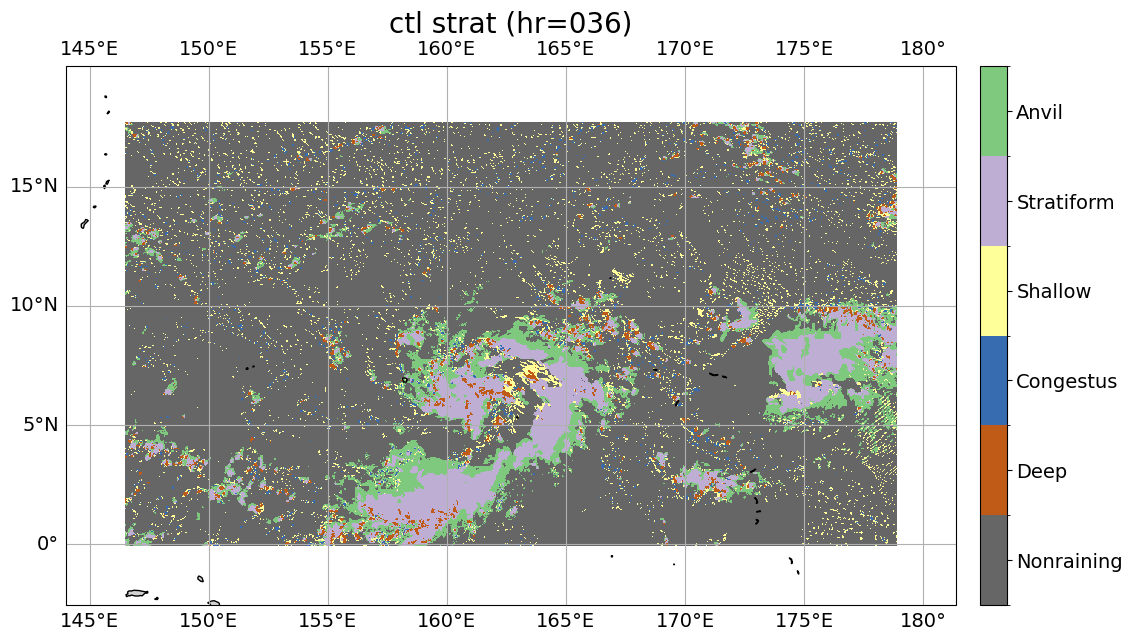

In [20]:
# ------ Stratiform plot

# hr_tag = str(np.char.zfill(str(t0), 3))
hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

vartag='strat'
# pltvar=strat
pltvar = mask_edges(strat2)
unittag='-'

# create figure
fig = plt.figure(figsize=(15,7))
proj = cartopy.crs.PlateCarree(central_longitude=offset)
ax = fig.add_subplot(111,projection=proj)
title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'
ax.set_title(title, fontsize=20)

istrat_mask = 2 # Mask out all but this
# pltvar = np.ma.masked_where((strat != istrat_mask),
#                             pltvar, copy=True)
# pltvar = np.ma.masked_where((strat == 1) | (strat == 2),
#                             pltvar, copy=True)
# ind_rain = (~((strat == 1) | (strat == 2))).nonzero()
ind_rain = (strat == 0).nonzero()
# pltvar[ind_rain[0],ind_rain[1]] = np.nan

# Poly fill approach
# bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5])
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
# cols=[(255,255,255),(174,53,85),(136,178,89),(70,99,200)]
# im = ax.pcolormesh(lon_offset_plt, lat, pltvar, norm=norm, cmap='plasma')
# cbar = plt.colorbar(im, ax=ax, shrink=0.75)
# cbar = plt.colorbar(im, ax=ax, shrink=0.3, ticks=(0,1,2,3))

bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)
nlevs = len(bounds) - 1
cmap = plt.get_cmap('Accent_r', nlevs)
im = ax.pcolormesh(lon_offset_plt, lat, pltvar, cmap=cmap, norm=norm)
cbar=plt.colorbar(im, ax=ax, fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
cbar.set_ticklabels(['Nonraining','Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil'])
cbar.ax.tick_params(labelsize=14)

# cbar.ax.set_ylabel(unittag)

# add map features
ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
# ax.add_feature(cartopy.feature.OCEAN) #ocean color
ax.add_feature(cartopy.feature.COASTLINE)
ax.gridlines(draw_labels=True, xlocs=np.arange(140,190,5), ylocs=np.arange(-10,20,5),
            dms=True, x_inline=False, y_inline=False)

# select plotting area
plt_area=[155, 165, -2, 10] # W,E,S,N
# ax.set_extent(plt_area)

plt.show()
plt.close()

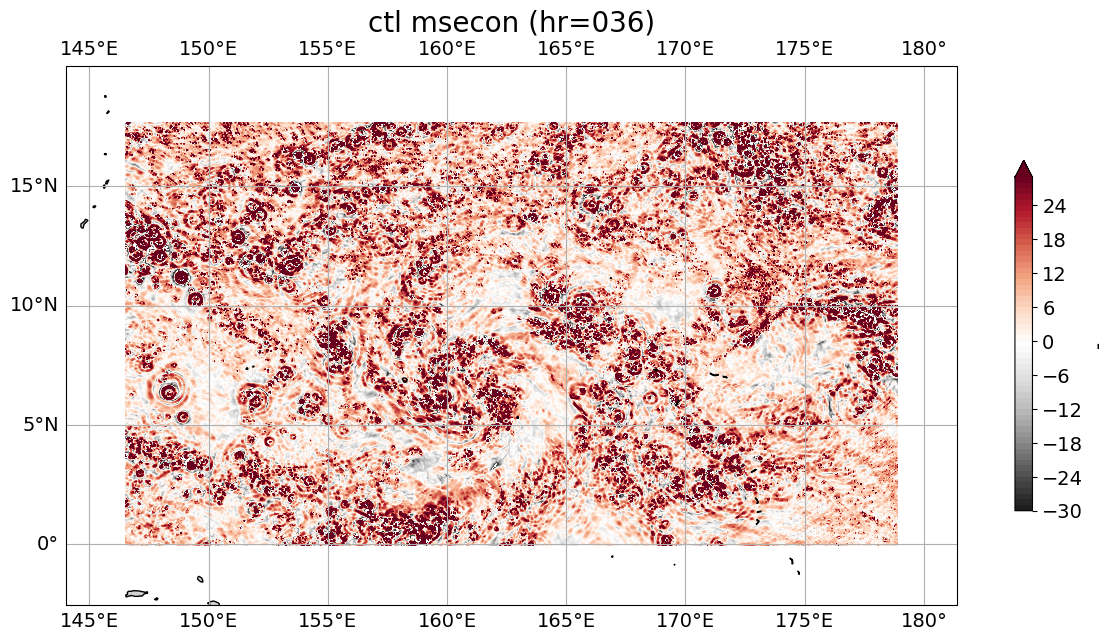

-0.2698030555785809


In [22]:
# ------ Plotting routines

# hr_tag = str(np.char.zfill(str(t0), 3))
hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

# for kplot in range(0,3):
# for kplot in range(0,3):
for kplot in range(1,2):

    if kplot == 0:
        vartag='dsecon-hflux'
        pltvar=grad_s_hf * 1e-3
        unittag='-'
    elif kplot == 1:
        vartag='msecon'
        pltvar=grad_h_vf * 1e-2
        unittag='-'
    elif kplot == 2:
        vartag='gms'
        pltvar=gms
        unittag='-'

    pltvar = mask_edges(pltvar)

    clevs = np.arange(-30,30)
    title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

    # Conduct smoothing using running average
    # nwindow = 5 # width = n * 3 km
    # pltvar_pd1 = pd.DataFrame(pltvar)
    # pltvar_pd2 = pltvar_pd1.rolling(window=nwindow, center=True, closed='both', axis=0).mean()
    # pltvar_pd = pltvar_pd2.rolling(window=nwindow, center=True, closed='both', axis=1).mean()
    # pltvar = np.copy(pltvar_pd)

    istrat_mask = 2 # Mask out all but this
    # pltvar = np.ma.masked_where((strat != istrat_mask),
    #                             pltvar, copy=True)
    # pltvar = np.ma.masked_where((strat == 1) | (strat == 2),
    #                             pltvar, copy=True)

    # do_plot(pltvar_pd, unittag, title, clevs)
    do_plot(pltvar, unittag, title, clevs)
    print(np.mean(pltvar))

In [43]:
def var_smooth(pltvar,nwindow):
    pltvar_pd1 = pd.DataFrame(pltvar)
    pltvar_pd2 = pltvar_pd1.rolling(window=nwindow, center=True, closed='both', axis=0).mean()
    pltvar_pd = pltvar_pd2.rolling(window=nwindow, center=True, closed='both', axis=1).mean()
    pltvar = np.copy(pltvar_pd)
    return pltvar

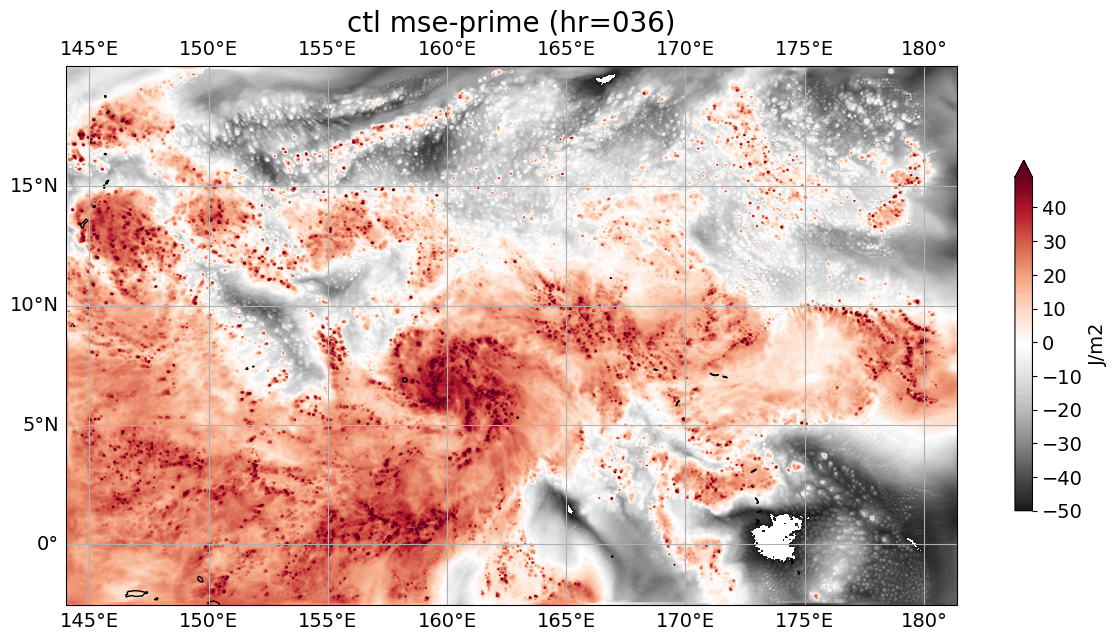

In [44]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

vartag='mse-prime'
pltvar=msep*1e-6
unittag='J/m2'

clevs = np.arange(-50,50)

# pltvar = mask_edges(pltvar)

title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

do_plot(pltvar, unittag, title, clevs)

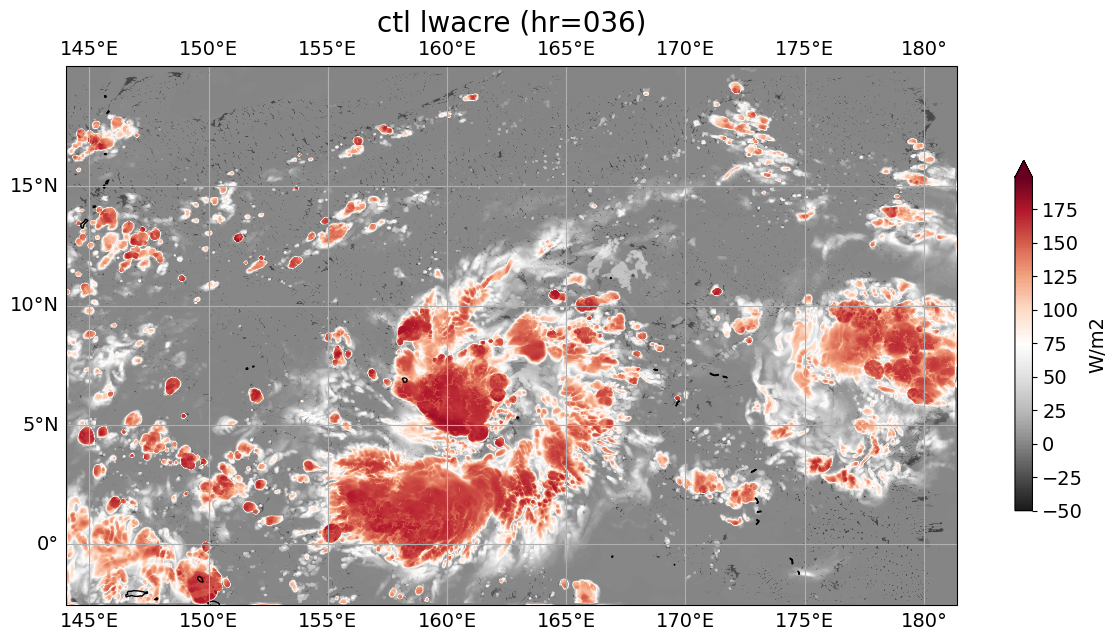

In [45]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

vartag='lwacre'
pltvar=acre
unittag='W/m2'

clevs = np.arange(-50,200)
# divnorm=colors.TwoSlopeNorm(vmin=clevs.min(), vcenter=0., vmax=clevs.max())

# pltvar = mask_edges(pltvar)

title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

do_plot(pltvar, unittag, title, clevs)

All:  0.103450246
Strat:  0.2980578037610939
Conv:  0.20625538811911553


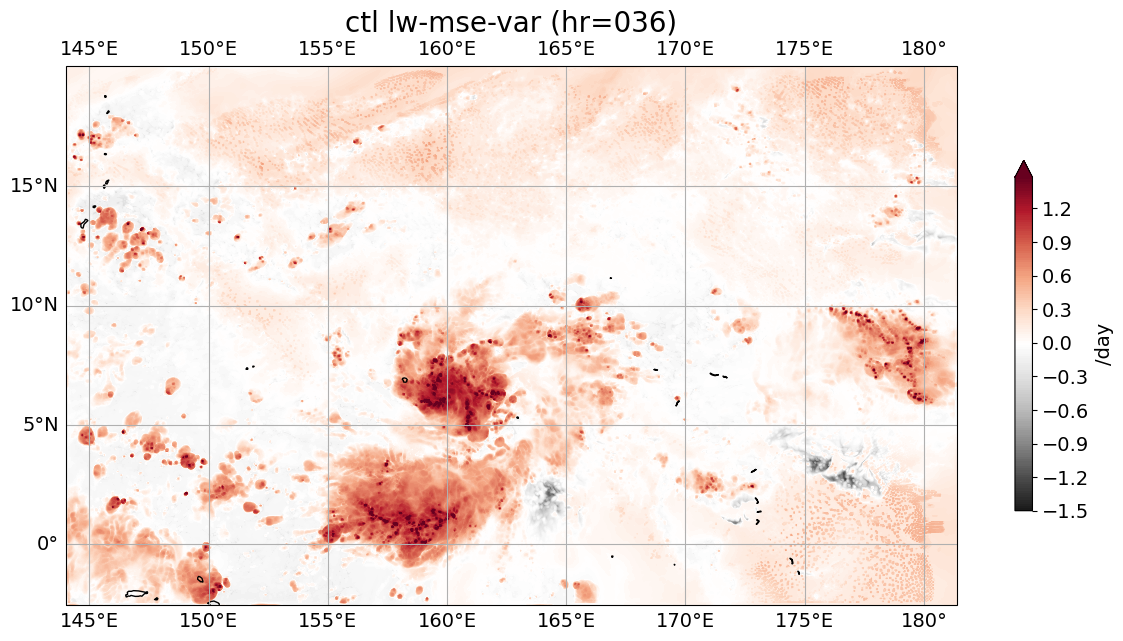

In [48]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

vartag='lw-mse-var'
pltvar=np.copy(lwmse)
unittag='/day'

print('All: ',np.mean(pltvar))
# pltvar_twpmask = np.ma.masked_where((twp <= 1e-2),pltvar,copy=True)
# print(np.mean(pltvar_twpmask))
pltvar_stratmask = np.ma.masked_where((strat < 2),pltvar,copy=True)
print('Strat: ',np.mean(pltvar_stratmask))
pltvar_convmask = np.ma.masked_where((strat != 1),pltvar,copy=True)
print('Conv: ',np.mean(pltvar_convmask))

# pltvar=pltvar_twpmask

clevs = np.arange(-1.5,1.5,0.02)

# pltvar = mask_edges(pltvar)

title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

do_plot(pltvar, unittag, title, clevs)

## SCATTER PLOTS
---

0.4236263925532968


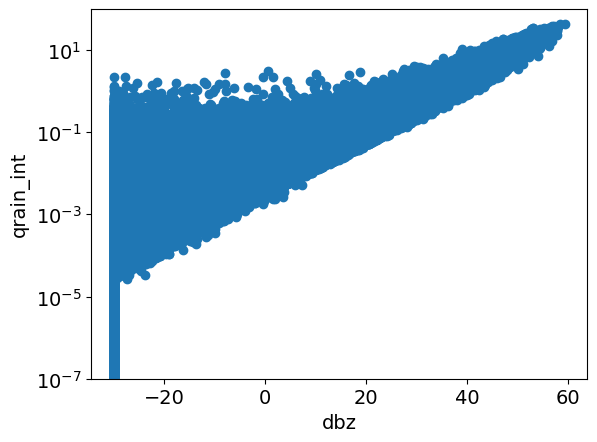

In [49]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

zlev1=0

var1 = dbz[0,:,:]
xtitle='dbz'
var2 = qrainwp
ytitle='qrain_int'

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(var1,var2)
# plt.plot(var1,var1,'k-') # identity line

# plt.plot([-20,70], [1e-4,1e-4], 'k-', color = 'r')
# plt.plot([-20,70], [1e-3,1e-3], 'k-', color = 'r')
# plt.plot([-20,70], [1e-2,1e-2], 'k-', color = 'r')
# plt.plot([45,45], [1e-9,10], 'k-', color = 'r')
# plt.plot([40,40], [1e-9,10], 'k-', color = 'r')
# plt.plot([30,30], [1e-9,10], 'k-', color = 'r')

# plt.title(title)
plt.xlabel(xtitle)
plt.ylabel(ytitle)

# plt.xlim([-10,65])
plt.ylim([1e-7,1e2])

ax.set_yscale('log')

plt.show()
plt.close()

0.23210138626730026


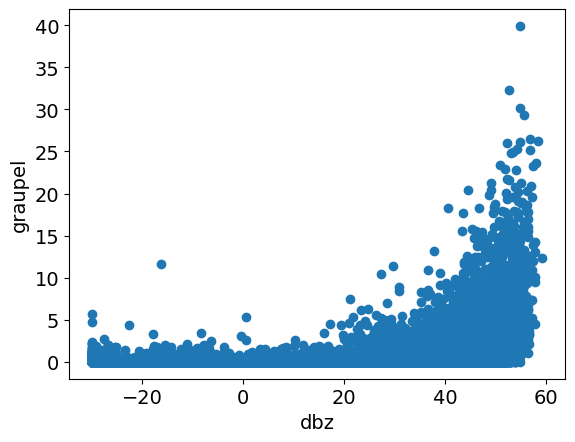

In [50]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

# title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

zlev1=0

var1 = dbz[0,:,:]
xtitle='dbz'
var2 = graupwp
ytitle='graupel'

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(var1,var2)
# plt.plot(var1,var1,'k-') # identity line

plt.xlabel(xtitle)
plt.ylabel(ytitle)

# plt.xlim([-10,65])
# plt.ylim([1e-7,1e-1])

# ax.set_yscale('log')

plt.show()
plt.close()

0.9880558481920663


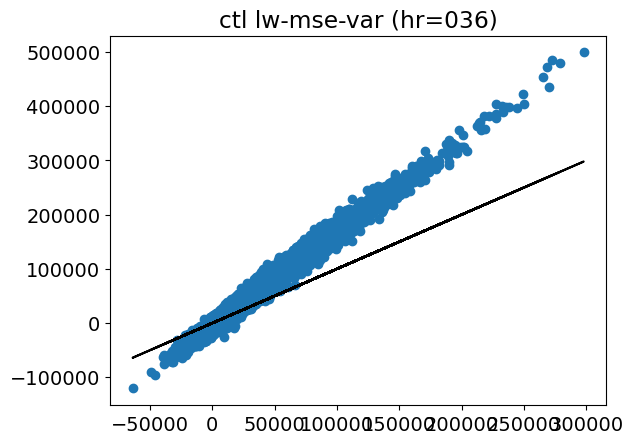

In [51]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

var1 = grad_s
var2 = aomeg

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

plt.scatter(var1,var2)
plt.plot(var1,var1,'k-') # identity line

plt.title(title)

plt.show()
plt.close()

0.4760133174436612


/tmp/ipykernel_31435/3692279001.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-20,70], [1e-4,1e-4], 'k-', color = 'r')
/tmp/ipykernel_31435/3692279001.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-20,70], [1e-3,1e-3], 'k-', color = 'r')
/tmp/ipykernel_31435/3692279001.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([-20,70], [1e-2,1e-2], 'k-', color = 'r')
/tmp/ipykernel_31435/3692279001.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([45,45], [1e-9,10], 'k-', color = 'r')
/tmp/ip

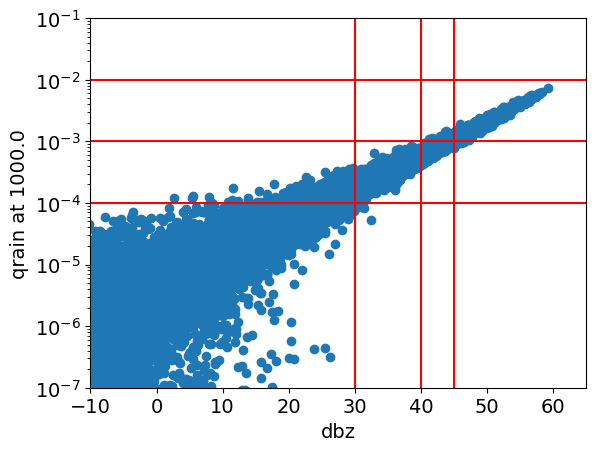

In [52]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

zlev1=0

var1 = dbz[0,:,:]
xtitle='dbz'
var2 = qrain[zlev1,:,:]
ytitle='qrain at '+str(pres[zlev1])

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.scatter(var1,var2)
# plt.plot(var1,var1,'k-') # identity line

plt.plot([-20,70], [1e-4,1e-4], 'k-', color = 'r')
plt.plot([-20,70], [1e-3,1e-3], 'k-', color = 'r')
plt.plot([-20,70], [1e-2,1e-2], 'k-', color = 'r')
plt.plot([45,45], [1e-9,10], 'k-', color = 'r')
plt.plot([40,40], [1e-9,10], 'k-', color = 'r')
plt.plot([30,30], [1e-9,10], 'k-', color = 'r')

# plt.title(title)
plt.xlabel(xtitle)
plt.ylabel(ytitle)

plt.xlim([-10,65])
plt.ylim([1e-7,1e-1])

ax.set_yscale('log')

plt.show()
plt.close()

0.9881444445631861


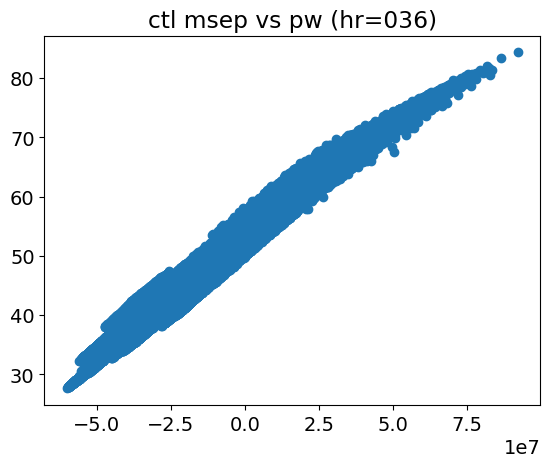

In [53]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

var1 = msep
var2 = pw

vartag='msep vs pw'
title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

plt.scatter(var1,var2)
# plt.plot(var1,var1,'k-') # identity line

plt.title(title)

plt.show()
plt.close()

0.37015798475766676


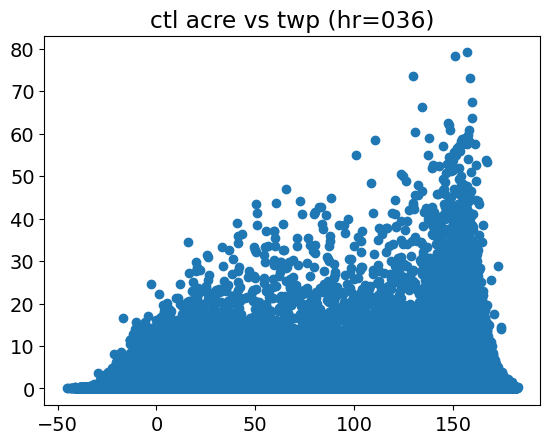

In [54]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

var1 = acre
var2 = twp

vartag='acre vs twp'
title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

plt.scatter(var1,var2)
# plt.plot(var1,var1,'k-') # identity line

plt.title(title)

plt.show()
plt.close()

0.9888664938534046


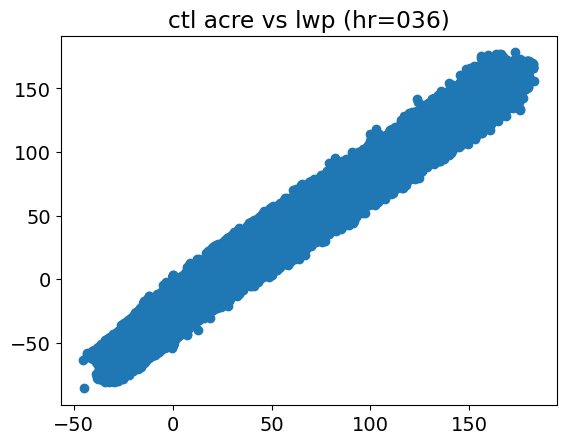

In [55]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

var1 = acre
var2 = lwp

vartag='acre vs lwp'
title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

plt.scatter(var1,var2)
# plt.plot(var1,var1,'k-') # identity line

plt.title(title)

plt.show()
plt.close()

0.4831359842584079


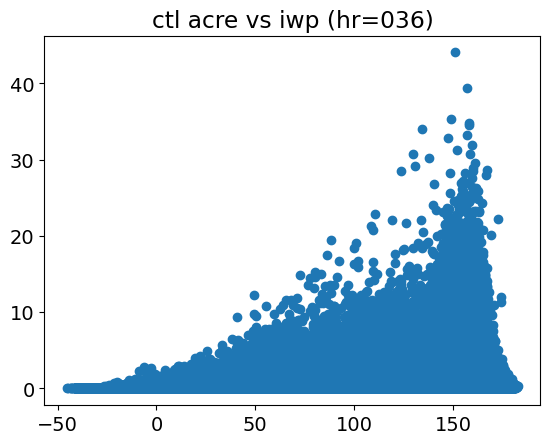

In [56]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

var1 = acre
var2 = iwp

vartag='acre vs iwp'
title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

plt.scatter(var1,var2)
# plt.plot(var1,var1,'k-') # identity line

plt.title(title)

plt.show()
plt.close()

-0.0713094907963258


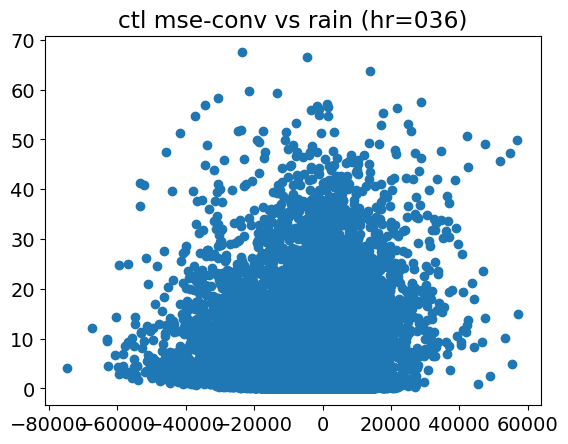

In [57]:
# ------ Plotting routines

hr_tag = str(np.char.zfill(str(it_plt[itest]), 3))

var1 = grad_h
var2 = rain

vartag='mse-conv vs rain'
title=tests[itest]+' '+vartag+' (hr='+hr_tag+')'

corr = np.corrcoef(var1.flatten(),var2.flatten())
print(corr[0,1])

plt.scatter(var1,var2)
# plt.plot(var1,var1,'k-') # identity line

plt.title(title)

plt.show()
plt.close()